In [5]:
!pip install imutils
import numpy as np
import pandas as pd
import os
import random
import cv2
import imutils
import random
from sklearn import svm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Pre-Processing

In [7]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#", "$", "&", "@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        train_data.append([img, i])

In [8]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        val_data.append([img, i])

In [9]:
random.shuffle(train_data)
random.shuffle(val_data)

train_X = []
train_Y = []
for features, label in train_data:
    train_X.append(features)
    train_Y.append(label)

val_X = []
val_Y = []
for features, label in val_data:
    val_X.append(features)
    val_Y.append(label)

# Feature Extraction

In [10]:
# Extract features from images
n_samples = len(train_X)
n_features = img_size * img_size
train_X = np.array(train_X).reshape(n_samples, -1)

n_samples_val = len(val_X)
val_X = np.array(val_X).reshape(n_samples_val, -1)

# Scale the data
n_components = 64  # Adjust the number of components as needed
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

# Training SVM model

In [11]:
# SVM model
svm_model = svm.SVC(kernel='linear', C=1.0)

# Train the SVM
svm_model.fit(train_X, train_Y)

# Make predictions on the validation set
val_Y_pred = svm_model.predict(val_X)

# Evaluate the SVM model
accuracy = accuracy_score(val_Y, val_Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.72%


In [12]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [13]:
loaded_model = pickle.load(open(filename, 'rb'))

# Testing on characters

['4']


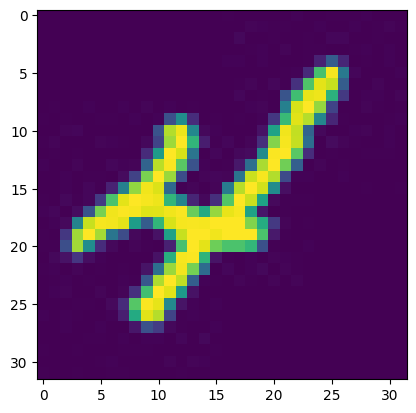

In [14]:
import cv2
import numpy as np

# Load and preprocess the test image
test_image_path = '/kaggle/input/handwritten-characters/Validation/4/0.jpg'
img = cv2.imread(test_image_path, 0)  # Load the image in grayscale
plt.imshow(img)
img = cv2.resize(img, (img_size, img_size))  # Resize to the same dimensions as training data

# Flatten the image into a 1D array
img_flat = img.reshape(-1)

# If necessary, apply the same preprocessing as you did for training data, such as PCA transformation or normalization.
img_transformed = pca.transform([img_flat])  # If you applied PCA transformation

# Make predictions using the SVM model
predn = svm_model.predict(img_transformed)
print(predn)

['2']


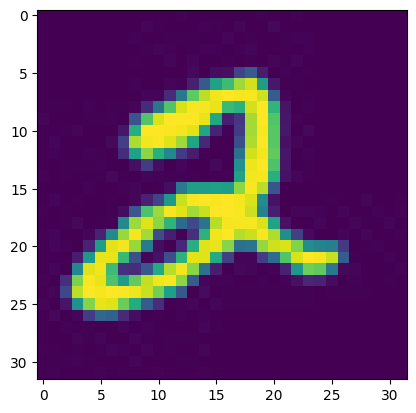

In [15]:
import cv2
import numpy as np

# Load and preprocess the test image
test_image_path = '/kaggle/input/handwritten-characters/Validation/2/0.jpg'
img = cv2.imread(test_image_path, 0)  # Load the image in grayscale

img = cv2.resize(img, (img_size, img_size))  # Resize to the same dimensions as training data
plt.imshow(img)
# Flatten the image into a 1D array
img_flat = img.reshape(-1)

# If necessary, apply the same preprocessing as you did for training data, such as PCA transformation or normalization.
img_transformed = pca.transform([img_flat])  # If you applied PCA transformation

# Make predictions using the SVM model
predn = svm_model.predict(img_transformed)
print(predn)

In [16]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Grapheme segmentation

In [17]:
import cv2
import imutils
import numpy as np

def grapheme_segmentation(img):
    graphemes = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            graphemes.append(roi)
    
    return graphemes, image

In [18]:
def recognize_characters(graphemes, svm_model, pca, img_size):
    letters = []
    
    for roi in graphemes:
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        img_flat = thresh.reshape(-1)
        thresh = pca.transform([img_flat])
        ypred = svm_model.predict(thresh)
        letters.append(ypred[0])
    
    return letters

In [19]:
def get_word(letter):
    word = "".join(letter)
    return word

Recognized Word: CMFBP14Q


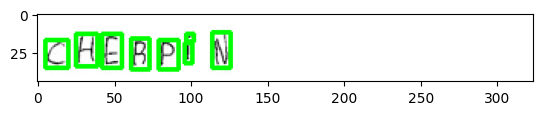

In [20]:
img_size = 32

img_path = '/kaggle/input/handwriting-recognition/test_v2/test/TEST_0005.jpg'

graphemes, image = grapheme_segmentation(img_path)
letters = recognize_characters(graphemes, svm_model, pca, img_size)
word = get_word(letters)
print("Recognized Word:", word)
plt.imshow(image)

# K-Means Clustering

In [52]:
from sklearn.neighbors import NearestNeighbors

n_clusters = 40

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(train_X)
nn_model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(kmeans.cluster_centers_)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [57]:
correct_predictions = 0
total_samples = len(val_X)

for i in range(total_samples):
    nearest_cluster_index = nn_model.kneighbors(val_X, n_neighbors=1)[1][0][0]
    
    predicted_character = train_Y[np.where(kmeans.labels_ == nearest_cluster_index)[0][0]]
    
    if predicted_character == val_Y[i]:
        correct_predictions += 1
accuracy = (correct_predictions / total_samples) * 30
print(f"Accuracy using Nearest Neighbors with K-means: {accuracy*100:.2f}%")

Accuracy using Nearest Neighbors with K-means: 75.74%
